# Setup

In [437]:
%matplotlib inline

import pandas as pd
import numpy as np
import re
import squarify
import copy

import matplotlib.pyplot as plt
import matplotlib

#Config metaplotlib
matplotlib.rcParams.update({'font.size': 20 }) #, 'font.weight' : 'bold'})
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

!pwd

pd.set_option('display.max_columns', None)

/Users/fruiz/Desktop/github/papers-stackage/pipelines/scripts/dataframes


In [846]:
lts_version = 'lts-0-7'
path_figure = f'/Users/fruiz/Desktop/github/papers-stackage/pipelines/scripts/dataframes/{lts_version}/'

df = pd.read_pickle(f'{lts_version}.df')
mtl_df = df[df['mtl-direct'] == 1]
df_by_cat = pd.read_pickle(f'{lts_version}-by-category.df')

In [847]:
mtl_df.iloc[0]

package                                                                BlastHTTP
version                                                                    1.0.1
stability                                                                       
cabal-file                     /Users/fruiz/Desktop/github/papers-stackage/pi...
categories                                                      [bioinformatics]
deps                           [http, base, biocore, blastxml, bytestring, co...
provided-modules                                                 [Bio.BlastHTTP]
src-dirs                                                                   [src]
main-modules                                                                  []
mtl-direct                                                                     1
provided-modules-found         [(Bio.BlastHTTP, ./StackageDownload/lts-0.7/Bl...
provided-modules-notfound                                                     []
main-modules-found          

# General statistics

In [848]:
total_pkgs = len(df)
total_pkgs_mtl = len(mtl_df)
per_pkgs_mtl = total_pkgs_mtl * 100 / total_pkgs

print(f'Total packages = {total_pkgs}')
print(f'Total packages using mtl directly = {total_pkgs_mtl}')
print(f'Percentage of packges using mtl directly = {per_pkgs_mtl:.2f}%')

Total packages = 815
Total packages using mtl directly = 174
Percentage of packges using mtl directly = 21.35%


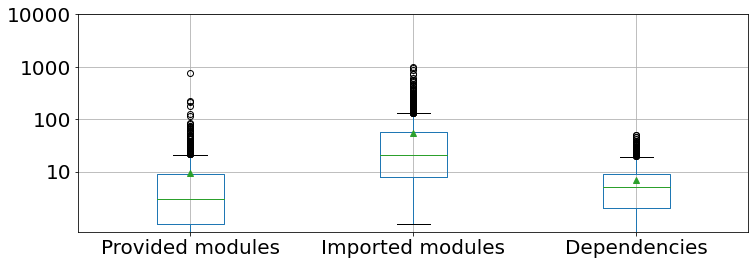

In [849]:
# to do: preguntar el tema de los "imported-modules", contienen rutas

qtyProvidedModules = df['provided-modules'].map(lambda x: len(x))
qtyImportedModules = df['imported-modules'].map(lambda x: len(x))
qtyDepsPerPackage  = df['deps'].map(lambda x: len(x))

desc_plotdf = pd.concat([qtyProvidedModules,qtyImportedModules, qtyDepsPerPackage], axis=1)
desc_plotdf.columns = ["Provided modules", "Imported modules", "Dependencies"]

ax, boxplot_1 = desc_plotdf.boxplot(
    figsize=(12, 4),
    vert=True,
    showmeans=True,
    showfliers=True,
    return_type='both'
)

ax.set_yscale('log')
ax.set_yticks([10, 100, 1000, 10000])
ax.set_yticklabels(["10", "100", "1000", "10000"])

plt.savefig(f"{path_figure}/modules_{lts_version}.png", bbox_inches='tight')

# By Category

In [850]:
def generateDataframeByCategory(df):
    """Takes a dataframe where a package has 1+ categories, and generates a new 
    dataframe with unique package-category combinations, hence reflecting
    the multiplicity of categories by package
    """
    
    multicat_criteria = df['category'].map(lambda x: len(x) > 1)    

    catdf = df.copy()
    for idx in catdf.index:
        if(len(catdf.loc[idx]['category']) == 1):
            theCat = catdf.loc[idx]['category'][0]
            catdf.loc[idx, 'category'] = theCat

    additionalrows = []

    for idx in catdf[multicat_criteria].index:
        currentRow = copy.deepcopy(df.loc[idx])
        for cat in currentRow['category']:        
            newRow = copy.deepcopy(currentRow)
            newRow['category'] = cat
            additionalrows.append(newRow)

    catdf = catdf.drop(catdf[multicat_criteria].index)
    catdf = catdf.append(additionalrows)
    catdf = catdf.sort_index()
    catdf.columns = ["category" if x == "categories" else x for x in catdf.columns.tolist()]
    catdf['category'] = catdf['category'].apply(str)
    
    return catdf

In [851]:
df_by_cat.head(3)
print(f'Total packages by categories = {len(df_by_cat)}')

Total packages by categories = 1118


In [852]:
def mergeUnique(values):
    return list(set(values))

cat_mtl_df = df_by_cat
cat_mtl_grouped = cat_mtl_df[["package","stability", "category", "mtl-direct"]].groupby('package')
cat_mtl_grouped = cat_mtl_grouped.agg({"stability": mergeUnique, "category": mergeUnique, "mtl-direct": np.max})

cat_mtl_grouped

,stability,category,mtl-direct
package,,,
AC-Vector,[experimental],"[numerical, math, data, graphics]",0
BlastHTTP,[],[bioinformatics],1
BlogLiterately,[experimental],[web],1
BlogLiterately-diagrams,[],[web],0
Boolean,[experimental],[data],0
...,...,...,...
zip-archive,[],[codec],1
zlib,[],[codec],0
zlib-bindings,[experimental],[codec],0


In [853]:
catsplit_df = generateDataframeByCategory(cat_mtl_grouped)

catsplit_df

,stability,category,mtl-direct
AC-Vector,[experimental],numerical,0
AC-Vector,[experimental],data,0
AC-Vector,[experimental],graphics,0
AC-Vector,[experimental],math,0
BlastHTTP,[],bioinformatics,1
...,...,...,...
zlib-bindings,[experimental],codec,0
zlib-enum,[experimental],compression,0
zlib-enum,[experimental],enumerator,0
zlib-enum,[experimental],codec,0


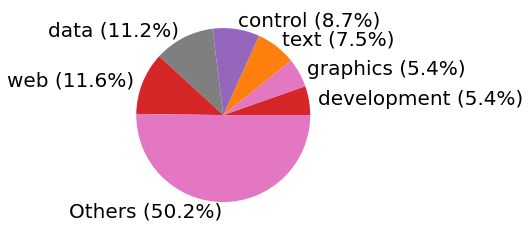

In [854]:
cat_groups = catsplit_df.groupby(['category', 'mtl-direct'])['mtl-direct'].count().unstack().fillna(0).rename(columns={0 : 'No direct dependency', 1:'Direct dependency'})
cat_groups['mtl-cat-pct'] = 100 * (cat_groups['Direct dependency']/(cat_groups['No direct dependency']+cat_groups['Direct dependency']))
total_cat_df_mtl_pkgs = cat_groups['Direct dependency'].sum()
total_cat_df_nomtl_pkgs = cat_groups['No direct dependency'].sum()
cat_groups_threshold = 5 #4
cat_groups['mtl-total-pct'] = 100 * (cat_groups['Direct dependency']/total_cat_df_mtl_pkgs)

totalCats = len(cat_groups)
catsNoMtl = cat_groups[cat_groups['mtl-total-pct'] == 0]
catsMtl = cat_groups[cat_groups['mtl-total-pct'] > 0]

cat_groups_no_others = cat_groups.copy(deep=True)

cat_groups.index = map(lambda x: u"{}".format(x.Index) if x._4 >= cat_groups_threshold else u"Others".format(cat_groups_threshold), cat_groups.itertuples())
cat_groups.index.name = 'category'
cat_groups = cat_groups.groupby(cat_groups.index).sum()
cat_groups = cat_groups.sort_values("mtl-total-pct")
cat_pie_colors = ['tab:red', 'tab:pink', 'tab:orange', 'tab:purple', 'tab:grey']
cat_groups['mtl-total-pct'].plot(kind='pie', colors=cat_pie_colors, labels=cat_groups.index.map(lambda x: "%s (%s)" % (x, "%1.1f%%" % cat_groups.loc[x]['mtl-total-pct']) if cat_groups.loc[x]['mtl-total-pct'] >= cat_groups_threshold else '')).set_ylabel('')

plt.savefig(f"{path_figure}/category_pie_{lts_version}.png", bbox_inches='tight')

In [855]:
total_cat_df_mtl_pkgs

241.0

In [856]:
total_cat_df_nomtl_pkgs

877.0

In [857]:
cat_groups_no_others['total-pkgs'] = cat_groups_no_others['No direct dependency'] + cat_groups_no_others['Direct dependency']
cat_groups_no_others.to_csv('categorys')

In [858]:
cat_groups_no_others.sum()

mtl-direct
No direct dependency     877.000000
Direct dependency        241.000000
mtl-cat-pct             2736.507478
mtl-total-pct            100.000000
total-pkgs              1118.000000
dtype: float64

In [859]:
total_pkgs = 3612
cat_groups_no_others['pkg-pct-of-total'] = np.round((cat_groups_no_others['total-pkgs'] / total_pkgs) *100, 1)
print(cat_groups_no_others.sort_values(by=['pkg-pct-of-total', 'total-pkgs'], ascending=False)[0:10][['total-pkgs', 'pkg-pct-of-total']].to_latex())

\begin{tabular}{lrr}
\toprule
mtl-direct &  total-pkgs &  pkg-pct-of-total \\
category    &             &                   \\
\midrule
data        &       155.0 &               4.3 \\
web         &        93.0 &               2.6 \\
control     &        78.0 &               2.2 \\
text        &        77.0 &               2.1 \\
system      &        49.0 &               1.4 \\
testing     &        41.0 &               1.1 \\
development &        37.0 &               1.0 \\
network     &        37.0 &               1.0 \\
yesod       &        36.0 &               1.0 \\
graphics    &        34.0 &               0.9 \\
\bottomrule
\end{tabular}



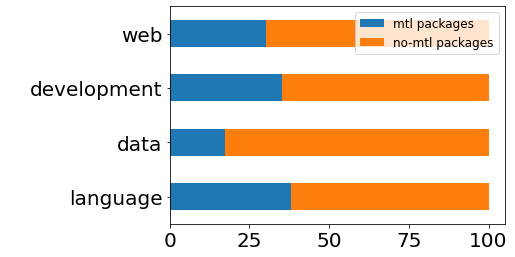

In [860]:
# to do: utililizar el top 10 de las categorias

import matplotlib.ticker as mtick

cat_groups_no_others = cat_groups_no_others.sort_values(by="mtl-cat-pct")
cat_groups_no_others['nomtl-cat-pct'] = 100 - cat_groups_no_others['mtl-cat-pct']
cat_groups_no_others[cat_groups_no_others['mtl-cat-pct'] > 0][['mtl-cat-pct', 'nomtl-cat-pct']].loc[['language', 'data', 'development', 'web']].plot(kind='barh', stacked=True, legend=True).set_ylabel(' ')

L = plt.legend(fontsize=12)
L.get_texts()[0].set_text('mtl packages')
L.get_texts()[1].set_text('no-mtl packages')

plt.savefig(f"{path_figure}/category_mtl_{lts_version}.png", bbox_inches='tight')

In [861]:
len(cat_groups_no_others)

124

In [862]:
cat_groups_no_others.loc["language"]

mtl-direct
No direct dependency    13.000000
Direct dependency        8.000000
mtl-cat-pct             38.095238
mtl-total-pct            3.319502
total-pkgs              21.000000
pkg-pct-of-total         0.600000
nomtl-cat-pct           61.904762
Name: language, dtype: float64

In [863]:
cat_groups_no_others['total-pkgs'] = cat_groups_no_others['No direct dependency'] + cat_groups_no_others['Direct dependency']
cat_groups_no_others[cat_groups_no_others['mtl-cat-pct'] > 0].sort_values(by="total-pkgs")

mtl-direct,No direct dependency,Direct dependency,mtl-cat-pct,mtl-total-pct,total-pkgs,pkg-pct-of-total,nomtl-cat-pct
category,,,,,,,
benchmarking,0.0,1.0,100.000000,0.414938,1.0,0.0,0.000000
adjunctions,0.0,1.0,100.000000,0.414938,1.0,0.0,0.000000
interfaces,0.0,1.0,100.000000,0.414938,1.0,0.0,0.000000
education,0.0,1.0,100.000000,0.414938,1.0,0.0,0.000000
aws,0.0,1.0,100.000000,0.414938,1.0,0.0,0.000000
image,0.0,1.0,100.000000,0.414938,1.0,0.0,0.000000
number theory,0.0,1.0,100.000000,0.414938,1.0,0.0,0.000000
performance,0.0,1.0,100.000000,0.414938,1.0,0.0,0.000000
happstack,0.0,1.0,100.000000,0.414938,1.0,0.0,0.000000


In [864]:
cat_groups_no_others.sort_values(by=['total-pkgs','mtl-cat-pct'], ascending=False)[0:20]

mtl-direct,No direct dependency,Direct dependency,mtl-cat-pct,mtl-total-pct,total-pkgs,pkg-pct-of-total,nomtl-cat-pct
category,,,,,,,
data,128.0,27.0,17.419355,11.203320,155.0,4.3,82.580645
web,65.0,28.0,30.107527,11.618257,93.0,2.6,69.892473
control,57.0,21.0,26.923077,8.713693,78.0,2.2,73.076923
text,59.0,18.0,23.376623,7.468880,77.0,2.1,76.623377
system,43.0,6.0,12.244898,2.489627,49.0,1.4,87.755102
testing,31.0,10.0,24.390244,4.149378,41.0,1.1,75.609756
development,24.0,13.0,35.135135,5.394191,37.0,1.0,64.864865
network,32.0,5.0,13.513514,2.074689,37.0,1.0,86.486486
yesod,33.0,3.0,8.333333,1.244813,36.0,1.0,91.666667


<ipython-input-865-4255ee901e7c>:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1_cat = plt.axes()


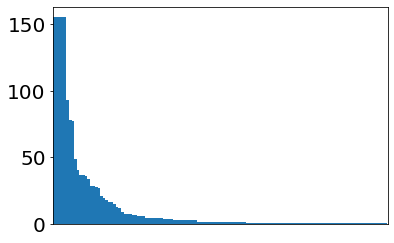

In [865]:
# distribucion de los paquetes
# todo: 

cat_groups_no_others.sort_values(by='total-pkgs', ascending=False)['total-pkgs'].plot(kind='bar', legend=False, width=5)
ax1_cat = plt.axes()
x_axis_cat = ax1_cat.axes.get_xaxis()
x_axis_cat.set_visible(False)

plt.savefig(f"{path_figure}/category_distribution_{lts_version}.png", bbox_inches='tight')

# By Stability

In [866]:
def generateDataframeByStability(df):
    """Takes a dataframe where a package has 1+ stabilities, and generates a new 
    dataframe with unique package-stability combinations, hence reflecting
    the multiplicity of stabilities by package
    """
    
    multicat_criteria = df['stability'].map(lambda x: len(x) > 1)    

    catdf = df.copy()
    for idx in catdf.index:
        if(len(catdf.loc[idx]['stability']) == 1):
            theCat = catdf.loc[idx]['stability'][0]
            catdf.loc[idx, 'stability'] = theCat

    additionalrows = []

    for idx in catdf[multicat_criteria].index:
        currentRow = copy.deepcopy(df.loc[idx])
        for cat in currentRow['stability']:        
            newRow = copy.deepcopy(currentRow)
            newRow['stability'] = cat
            additionalrows.append(newRow)

    catdf = catdf.drop(catdf[multicat_criteria].index)
    catdf = catdf.append(additionalrows)
    catdf = catdf.sort_index()
    catdf.columns = ["stability" if x == "stability" else x for x in catdf.columns.tolist()]
    catdf['stability'] = catdf['stability'].apply(str)
    
    return catdf

In [867]:
stabsplit_df = generateDataframeByStability(cat_mtl_grouped)
stabsplit_df

,stability,category,mtl-direct
package,,,
AC-Vector,experimental,"[numerical, math, data, graphics]",0
BlastHTTP,,[bioinformatics],1
BlogLiterately,experimental,[web],1
BlogLiterately-diagrams,,[web],0
Boolean,experimental,[data],0
...,...,...,...
zip-archive,,[codec],1
zlib,,[codec],0
zlib-bindings,experimental,[codec],0


In [868]:
len(stabsplit_df)

815

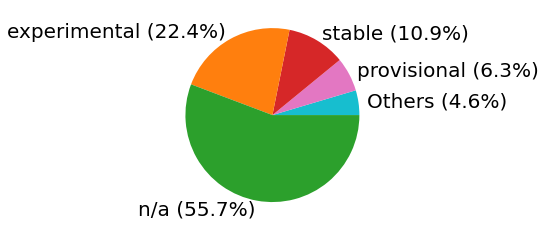

In [869]:
stab_groups = stabsplit_df.groupby(['stability', 'mtl-direct'])['mtl-direct'].count().unstack().fillna(0).rename(columns={0 : 'No direct dependency', 1:'Direct dependency'})
stab_groups['mtl-stab-pct'] = 100 * (stab_groups['Direct dependency']/(stab_groups['No direct dependency']+stab_groups['Direct dependency']))
total_stab_df_mtl_pkgs = stab_groups['Direct dependency'].sum()

stab_groups_threshold = 3
stab_groups['mtl-total-pct'] = 100 * (stab_groups['Direct dependency']/total_stab_df_mtl_pkgs)

totalStabs = len(stab_groups)
stabsNoMtl = stab_groups[stab_groups['mtl-total-pct'] == 0]
stabsMtl = stab_groups[stab_groups['mtl-total-pct'] > 0]

stab_groups_no_others = stab_groups.copy(deep=True)
stab_groups_no_others = stab_groups_no_others.rename(index={'': 'n/a'})

stab_groups.index = map(lambda x: u"{}".format(x.Index) if x._4 >= stab_groups_threshold else u"Others", stab_groups.itertuples())
stab_groups.index.name = 'stability'
stab_groups = stab_groups.groupby(stab_groups.index).sum()
stab_groups = stab_groups.sort_values("mtl-total-pct")

stab_pie_colors = ['tab:cyan', 'tab:pink', 'tab:red', 'tab:orange', 'tab:green', 'tab:grey']
stab_groups['mtl-total-pct'].plot(kind='pie', colors=stab_pie_colors, labels = stab_groups.index.map(lambda x: "%s (%s)" % (x if x else "n/a",  "%1.1f%%" % stab_groups.loc[x]['mtl-total-pct']) if stab_groups.loc[x]['mtl-total-pct'] >= stab_groups_threshold else ''), legend=False).set_ylabel('')

plt.savefig(f"{path_figure}/stability_pie_{lts_version}.png", bbox_inches='tight')

In [870]:
total_stab_df_mtl_pkgs

174.0

In [871]:
stab_groups.sum()

mtl-direct
No direct dependency    641.000000
Direct dependency       174.000000
mtl-stab-pct            191.210215
mtl-total-pct           100.000000
dtype: float64

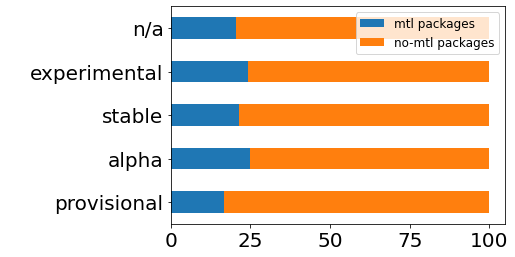

In [872]:
stab_groups_no_others['total-pkgs'] = stab_groups_no_others['No direct dependency'] + stab_groups_no_others['Direct dependency']
stab_groups_no_others = stab_groups_no_others.sort_values(by="mtl-stab-pct")
stab_groups_no_others['nomtl-stab-pct'] = 100 - stab_groups_no_others['mtl-stab-pct']

stab_groups_no_others[['mtl-stab-pct', 'nomtl-stab-pct']].loc[['provisional', 'alpha', 'stable', 'experimental', 'n/a']].plot(kind='barh', stacked=True).set_ylabel(' ')

Lstab = plt.legend(fontsize=12)
Lstab.get_texts()[0].set_text('mtl packages')
Lstab.get_texts()[1].set_text('no-mtl packages')

plt.savefig(f"{path_figure}/stability_mtl_{lts_version}.png", bbox_inches='tight')

In [873]:
stab_groups_no_others.sum()

mtl-direct
No direct dependency     641.000000
Direct dependency        174.000000
mtl-stab-pct             191.210215
mtl-total-pct            100.000000
total-pkgs               815.000000
nomtl-stab-pct          1008.789785
dtype: float64

In [874]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(stab_groups_no_others.sort_values(by=['total-pkgs', 'stability'], ascending=False))

mtl-direct,No direct dependency,Direct dependency,mtl-stab-pct,mtl-total-pct,total-pkgs,nomtl-stab-pct
stability,,,,,,
n/a,373.0,97.0,20.638298,55.747126,470.0,79.361702
experimental,122.0,39.0,24.223602,22.413793,161.0,75.776398
stable,70.0,19.0,21.348315,10.919540,89.0,78.651685
provisional,55.0,11.0,16.666667,6.321839,66.0,83.333333
beta,4.0,4.0,50.000000,2.298851,8.0,50.000000
alpha,6.0,2.0,25.000000,1.149425,8.0,75.000000
seems to work,4.0,2.0,33.333333,1.149425,6.0,66.666667
unstable,3.0,0.0,0.000000,0.000000,3.0,100.000000
stable api,1.0,0.0,0.000000,0.000000,1.0,100.000000


<ipython-input-875-56f01ee3b7f6>:2: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = plt.axes()


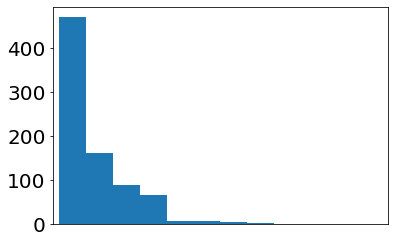

In [875]:
stab_groups_no_others.sort_values(by=['total-pkgs'], ascending=False)['total-pkgs'].plot(kind='bar', width=1, legend=False)
ax1 = plt.axes()
x_axis = ax1.axes.get_xaxis()
x_axis.set_visible(False)

<ipython-input-876-f757c3205609>:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = plt.axes()


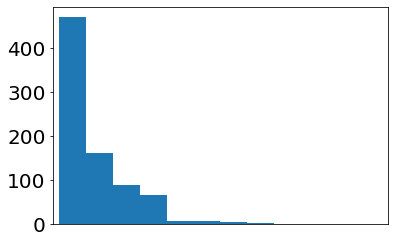

In [876]:
dfff = stab_groups_no_others.rename(index={'': 'n/a'}).sort_values(by=['total-pkgs'], ascending=False)['total-pkgs']
dfff.plot(kind='bar', width=1)
ax1 = plt.axes()
x_axis = ax1.axes.get_xaxis()
x_axis.set_visible(False)

<AxesSubplot:xlabel='stability'>

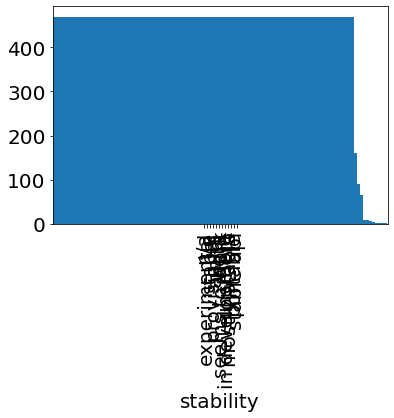

In [877]:
stab_groups_no_others.sort_values(by=['total-pkgs'], ascending=False)['total-pkgs'].plot(kind='bar', width=100, legend=False)

In [878]:
total_stab_pkgs = 2403
stab_groups_no_others['pkg-pct-of-total'] = np.round((stab_groups_no_others['total-pkgs'] / total_stab_pkgs * 100), 1)
print(stab_groups_no_others.sort_values(by=['pkg-pct-of-total','total-pkgs'], ascending=False)[['total-pkgs', 'pkg-pct-of-total']][0:8].to_latex())

\begin{tabular}{lrr}
\toprule
mtl-direct &  total-pkgs &  pkg-pct-of-total \\
stability     &             &                   \\
\midrule
n/a           &       470.0 &              19.6 \\
experimental  &       161.0 &               6.7 \\
stable        &        89.0 &               3.7 \\
provisional   &        66.0 &               2.7 \\
alpha         &         8.0 &               0.3 \\
beta          &         8.0 &               0.3 \\
seems to work &         6.0 &               0.2 \\
unstable      &         3.0 &               0.1 \\
\bottomrule
\end{tabular}



# Monads Usage

In [879]:
mtl_modules = [
      "Control.Monad.Cont"
    , "Control.Monad.Cont.Class"
    , "Control.Monad.Error"
    , "Control.Monad.Error.Class"
    , "Control.Monad.Except"
    , "Control.Monad.Identity"
    , "Control.Monad.List"
    , "Control.Monad.RWS"
    , "Control.Monad.RWS.Class"
    , "Control.Monad.RWS.Lazy"
    , "Control.Monad.RWS.Strict"
    , "Control.Monad.Reader"
    , "Control.Monad.Reader.Class"
    , "Control.Monad.State"
    , "Control.Monad.State.Class"
    , "Control.Monad.State.Lazy"
    , "Control.Monad.State.Strict"
    , "Control.Monad.Trans"
    , "Control.Monad.Writer"
    , "Control.Monad.Writer.Class"
    , "Control.Monad.Writer.Lazy"
    , "Control.Monad.Writer.Strict"
    ]

mtl_monads = ['Continuation', 'Error', 'Except', 'Identity', 'List', 'RWS', 'Reader', 'State', 'Trans', 'Writer']

def computeMonadUsageForDataframe(theDf):

    mtl_cont = mtl_modules[0:2]
    mtl_error = mtl_modules[2:4]
    mtl_except = mtl_modules[4:5]
    mtl_identity= mtl_modules[5:6]
    mtl_list = mtl_modules[6:7]
    mtl_rws = mtl_modules[7:11]
    mtl_reader = mtl_modules[11:13]
    mtl_state = mtl_modules[13:17]
    mtl_trans = mtl_modules[17:18]
    mtl_writer = mtl_modules[18:]    
    
    theDf.loc[theDf.index, 'Continuation']  = theDf[mtl_cont].sum(axis=1).apply(lambda x: 1 if x > 0 else 0)
    theDf.loc[theDf.index, 'Error']         = theDf[mtl_error].sum(axis=1).apply(lambda x: 1 if x > 0 else 0)
    theDf.loc[theDf.index, 'Except']        = theDf[mtl_except].sum(axis=1).apply(lambda x: 1 if x > 0 else 0)
    theDf.loc[theDf.index, 'Identity']      = theDf[mtl_identity].sum(axis=1).apply(lambda x: 1 if x > 0 else 0)
    theDf.loc[theDf.index, 'List']          = theDf[mtl_list].sum(axis=1).apply(lambda x: 1 if x > 0 else 0)
    theDf.loc[theDf.index, 'RWS']           = theDf[mtl_rws].sum(axis=1).apply(lambda x: 1 if x > 0 else 0)
    theDf.loc[theDf.index, 'Reader']        = theDf[mtl_reader].sum(axis=1).apply(lambda x: 1 if x > 0 else 0)
    theDf.loc[theDf.index, 'State']         = theDf[mtl_state].sum(axis=1).apply(lambda x: 1 if x > 0 else 0)
    theDf.loc[theDf.index, 'Trans']         = theDf[mtl_trans].sum(axis=1).apply(lambda x: 1 if x > 0 else 0)
    theDf.loc[theDf.index, 'Writer']        = theDf[mtl_writer].sum(axis=1).apply(lambda x: 1 if x > 0 else 0)
    theDf.loc[theDf.index, 'MonadsUsed']    = theDf[mtl_monads].sum(axis=1)
    
    return theDf

In [880]:
mtl_df = computeMonadUsageForDataframe(mtl_df)
mtl_df[mtl_monads].sum().sort_values()

/usr/local/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


Except           1
List             4
Continuation    19
RWS             22
Identity        28
Writer          38
Trans           47
Error           56
Reader          63
State           89
dtype: int64

Text(0, 0.5, '')

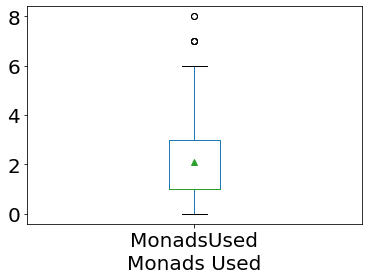

In [881]:
axn = mtl_df['MonadsUsed'].plot(kind='box', showmeans=True, legend=False)
axn.set_xlabel("Monads Used")
axn.set_ylabel("")

In [882]:
def getParsingStatusFromDataFrame(theDf):

    ### Mark how many parsing errors there are per package
    df_pkgsWithErrors = theDf['imported-modules'].map(lambda x: (x, map(lambda y: "IsmaParseError" in y, x)))
    df_errorsPerPkg = df_pkgsWithErrors.map(lambda x: ( sum([(1 if y else 0) for y in x[1]])
                                                                    ,sum([(1 if not y else 0) for y in x[1]])
                                                                    , x[0]))

    ### How many of these packages have parsing errors?
    df_with_parse_errors_idx = df_errorsPerPkg.map(lambda x: x[0] > 0)
    df_with_parse_errors     = df_errorsPerPkg[df_with_parse_errors_idx]

    ### How many of these packages do not have parsing errors?
    df_without_parse_errors_idx = df_errorsPerPkg.map(lambda x: x[0] == 0)
    df_without_parse_errors     = df_errorsPerPkg[df_without_parse_errors_idx]
    
    return df_with_parse_errors, df_without_parse_errors

In [883]:
### How many packages are mtl-packages with MonadsUsed == 0 and MonadsUsed > 0?
mtl_df_0_parse_errors, mtl_df_0_no_parse_errors = getParsingStatusFromDataFrame(mtl_df[mtl_df['MonadsUsed'] == 0])
mtl_df_g0_parse_errors, mtl_df_g0_no_parse_errors = getParsingStatusFromDataFrame(mtl_df[mtl_df['MonadsUsed'] > 0])
print(len(mtl_df_0_parse_errors))
print(len(mtl_df_0_no_parse_errors))
print(len(mtl_df_g0_parse_errors))
print(len(mtl_df_g0_no_parse_errors))

9
16
44
105


# MTL  Packages

In [1]:
mtl_usage = mtl_df.groupby(['MonadsUsed'])['MonadsUsed'].count()
mtl_ax = mtl_usage.plot(figsize=(5,5), kind='bar', rot=360, color='blue', legend=False)
mtl_ax.set_xlabel('# Monads', fontsize=20)
mtl_ax.set_ylabel('# Packages', fontsize=20)


plt.savefig(f"{path_figure}/mtl_monads_usage_{lts_version}.png", bbox_inches='tight')

NameError: name 'mtl_df' is not defined

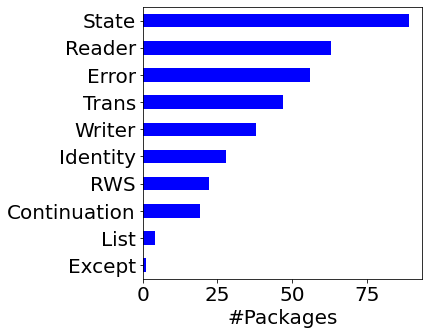

In [885]:
mtl_per_monad_usage = mtl_df[mtl_monads].sum().sort_values()
mtl_per_monad_ax = mtl_per_monad_usage.plot(figsize=(5,5), kind='barh', color='blue', log=False)
mtl_per_monad_ax.set_xlabel('#Packages', fontsize=20)

plt.savefig(f"{path_figure}/mtl_monads_type_usage_{lts_version}.png", bbox_inches='tight')

In [886]:
cont_mods   = ("Continuation", ["Control.Monad.Cont", "Control.Monad.Cont.Class"])
error_mods  = ("Error", ["Control.Monad.Error", "Control.Monad.Error.Class"])
reader_mods = ("Reader", ["Control.Monad.Reader", "Control.Monad.Reader.Class"])
writer_mods = ("Writer", ["Control.Monad.Writer", "Control.Monad.Writer.Class", "Control.Monad.Writer.Lazy", "Control.Monad.Writer.Strict"])
state_mods  = ("State", ["Control.Monad.State", "Control.Monad.State.Class", "Control.Monad.State.Lazy", "Control.Monad.State.Strict"])
rws_mods    = ("RWS", ["Control.Monad.RWS", "Control.Monad.RWS.Class", "Control.Monad.RWS.Lazy", "Control.Monad.RWS.Strict"])

except_mods = ("Except", ["Control.Monad.Except"])
ident_mods  = ("Identity", ["Control.Monad.Identity"])
list_mods   = ("List", ["Control.Monad.List"])

# to do: Incluior trans en el proceso de creacion del data frame

trans_mods  = ("Trans", ["Control.Monad.Trans"]) #, "Control.Monad.Trans.Class"])

monads_defs = [cont_mods, error_mods, rws_mods, reader_mods, writer_mods, state_mods, trans_mods]

In [887]:
def usageCombinationToString(usage_vector):
    letters = ('C', 'E', 'I', 'L', 'R', 'S', 'T', 'W', 'X', 'Z')    
    combStr = "".join(list(map(lambda x: x[1] if x[0] == 1 else "", zip(usage_vector, letters))))
    if combStr == "":
        combStr = "None"
    return combStr

def generateMonadDataframes(theDf):
    monad_dfs  = {}    
    for mdef in monads_defs:        
        monad_name    = mdef[0]
        monad_details = theDf[mdef[1]].sum()
        monad_dfs[monad_name] = pd.DataFrame(columns = mdef[1])
        monad_dfs[monad_name] = pd.concat([monad_dfs[monad_name], monad_details.to_frame().T])
        monad_dfs[monad_name].index = ["Total"]
        
    return monad_dfs

In [888]:
pkgVersionGroup = mtl_df[["package", "version"]].groupby("package").count()
len(pkgVersionGroup)

174

In [889]:
mdfs = generateMonadDataframes(mtl_df)
mdfs

{'Continuation':       Control.Monad.Cont Control.Monad.Cont.Class
 Total                 10                        9,
 'Error':       Control.Monad.Error Control.Monad.Error.Class
 Total                  41                        16,
 'RWS':       Control.Monad.RWS Control.Monad.RWS.Class Control.Monad.RWS.Lazy  \
 Total                 7                       4                      7   
 
       Control.Monad.RWS.Strict  
 Total                       11  ,
 'Reader':       Control.Monad.Reader Control.Monad.Reader.Class
 Total                   51                         19,
 'Writer':       Control.Monad.Writer Control.Monad.Writer.Class  \
 Total                   18                         16   
 
       Control.Monad.Writer.Lazy Control.Monad.Writer.Strict  
 Total                         8                           9  ,
 'State':       Control.Monad.State Control.Monad.State.Class Control.Monad.State.Lazy  \
 Total                  61                        22                   

In [890]:
split_df = pd.DataFrame(columns = ["Top-level Module", "Class Module", "Lazy Variant", "Strict Variant"])

for key in mdfs:    
    topLevel      = mdfs[key].iloc[0][0]
    classLevel    = mdfs[key].iloc[0][1]
    lazyVariant   = 0
    strictVariant = 0
    if key in ["RWS", "Writer", "State"]:
        lazyVariant   = mdfs[key].iloc[0][2]
        strictVariant = mdfs[key].iloc[0][3]
    
    split_df.loc[key] = [topLevel, classLevel, lazyVariant, strictVariant]   

split_df

IndexError: index 1 is out of bounds for axis 0 with size 1

In [ ]:
pre_ranking = mtl_df['MonadsUsedVector'].value_counts().to_frame("Total Frequency")
pre_ranking.index = map(usageCombinationToString, pre_ranking.index)
pre_ranking

<AxesSubplot:>

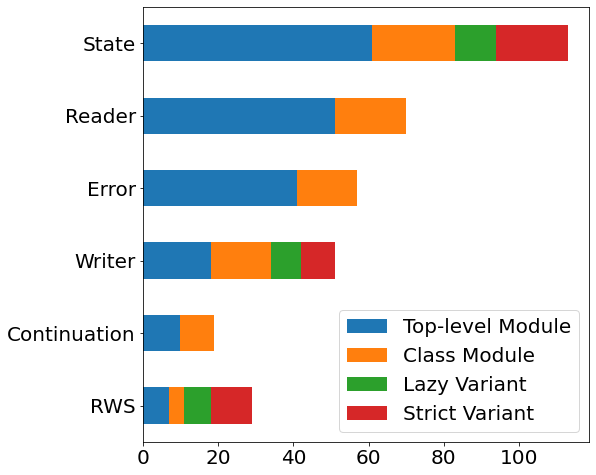

In [891]:
ax = plt.figure(figsize=(8,8)).add_subplot(111)
dfy = split_df.sort_values(by="Top-level Module")
dfy.plot(ax=ax, kind='barh', stacked=True, legend=True)

<AxesSubplot:>

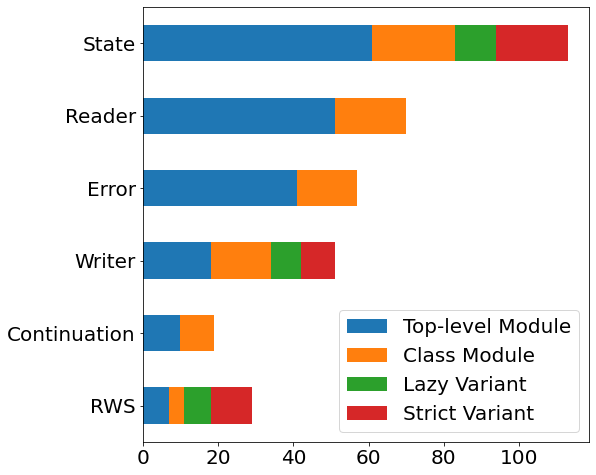

In [892]:
ax = plt.figure(figsize=(8,8)).add_subplot(111)
dfy = split_df.sort_values(by="Top-level Module")
dfy.plot(ax=ax, kind='barh', stacked=True, legend=True)

In [893]:
ranking = mtl_df['MonadsUsedVector'].value_counts().to_frame("Total Frequency")
ranking.index = map(usageCombinationToString, ranking.index)
ranking.take(range(0, 11)).sort_values(by="Total Frequency").plot(kind='barh')

KeyError: 'MonadsUsedVector'

In [894]:
enum_ranking = ranking.sort_values(by="Total Frequency", ascending=False).reset_index()
enum_ranking

NameError: name 'ranking' is not defined

In [895]:
ranking.plot(kind='bar', log=False, legend=False, width=10)
ax1 = plt.axes()
x_axis = ax1.axes.get_xaxis()
x_axis.set_visible(False)

NameError: name 'ranking' is not defined

In [896]:
def containsCombination(df, c):
    return df.apply(lambda row: all(map(lambda x: x in row["index"], c)), axis = 1)

def notContainsCombination(df, c):
    return df.apply(lambda row: all(map(lambda x: x not in row["index"], c)), axis = 1)

def exclusivelyContainsCombination(df, c):
    return df.apply(lambda row: row["MonadsUsedCode"] == c, axis = 1)

combinationsNoState = enum_ranking[notContainsCombination(enum_ranking, "S")]
combinationsNoTrans = enum_ranking[notContainsCombination(enum_ranking, "T")]
combinationsNoReader = enum_ranking[notContainsCombination(enum_ranking, "R")]


print("No State: %s - No Trans: %s - No Reader: %s" % (len(combinationsNoState),
                                                       len(combinationsNoTrans),
                                                       len(combinationsNoReader)))

NameError: name 'enum_ranking' is not defined

# No MTL Packages

In [897]:
def computeMonadUsageForDataframe(theDf):

    mtl_cont = mtl_modules[0:2]
    mtl_error = mtl_modules[2:4]
    mtl_except = mtl_modules[4:5]
    mtl_identity= mtl_modules[5:6]
    mtl_list = mtl_modules[6:7]
    mtl_rws = mtl_modules[7:11]
    mtl_reader = mtl_modules[11:13]
    mtl_state = mtl_modules[13:17]
    mtl_trans = mtl_modules[17:18]
    mtl_writer = mtl_modules[18:]    
    
    theDf.loc[theDf.index, 'Continuation']  = theDf[mtl_cont].sum(axis=1).apply(lambda x: 1 if x > 0 else 0)
    theDf.loc[theDf.index, 'Error']         = theDf[mtl_error].sum(axis=1).apply(lambda x: 1 if x > 0 else 0)
    theDf.loc[theDf.index, 'Except']        = theDf[mtl_except].sum(axis=1).apply(lambda x: 1 if x > 0 else 0)
    theDf.loc[theDf.index, 'Identity']      = theDf[mtl_identity].sum(axis=1).apply(lambda x: 1 if x > 0 else 0)
    theDf.loc[theDf.index, 'List']          = theDf[mtl_list].sum(axis=1).apply(lambda x: 1 if x > 0 else 0)
    theDf.loc[theDf.index, 'RWS']           = theDf[mtl_rws].sum(axis=1).apply(lambda x: 1 if x > 0 else 0)
    theDf.loc[theDf.index, 'Reader']        = theDf[mtl_reader].sum(axis=1).apply(lambda x: 1 if x > 0 else 0)
    theDf.loc[theDf.index, 'State']         = theDf[mtl_state].sum(axis=1).apply(lambda x: 1 if x > 0 else 0)
    theDf.loc[theDf.index, 'Trans']         = theDf[mtl_trans].sum(axis=1).apply(lambda x: 1 if x > 0 else 0)
    theDf.loc[theDf.index, 'Writer']        = theDf[mtl_writer].sum(axis=1).apply(lambda x: 1 if x > 0 else 0)
    theDf.loc[theDf.index, 'MonadsUsed']    = theDf[mtl_monads].sum(axis=1)
    
    return theDf

nomtl_df = df[df['mtl-direct'] == 0]
nomtl_df = computeMonadUsageForDataframe(nomtl_df)
len(nomtl_df)

/usr/local/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


641

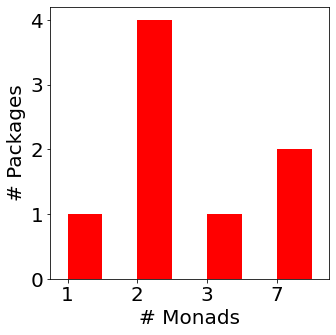

In [898]:
nomtl_usage = nomtl_df.groupby(['MonadsUsed'])['MonadsUsed'].count()
nomtl_usage_plot = nomtl_usage.drop(0)
nomtl_ax = nomtl_usage_plot.plot(figsize=(5,5), kind='bar', rot=360, position=0, color='red', legend=False)
nomtl_ax.set_xlabel('# Monads', fontsize=20)
nomtl_ax.set_ylabel('# Packages', fontsize=20)

plt.savefig(f"{path_figure}/nomtl_monads_usage_{lts_version}.png", bbox_inches='tight')

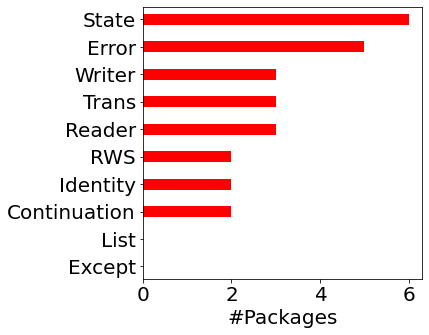

In [899]:
nomtl_per_monad_usage = nomtl_df[mtl_monads].sum().sort_values()
nomtl_per_monad_ax = nomtl_per_monad_usage.plot(figsize=(5,5), kind='barh', color='red', log=False, width=0.4)
nomtl_per_monad_ax.set_xlabel('#Packages', fontsize=20)

plt.savefig(f"{path_figure}/nomtl_monads_type_usage_{lts_version}.png", bbox_inches='tight')

In [900]:
nomtl_mdfs = df[df['mtl-direct'] == 0]
nomtl_mdfs = generateMonadDataframes(nomtl_mdfs)
nomtl_mdfs

{'Continuation':       Control.Monad.Cont Control.Monad.Cont.Class
 Total                  0                        2,
 'Error':       Control.Monad.Error Control.Monad.Error.Class
 Total                   3                         2,
 'RWS':       Control.Monad.RWS Control.Monad.RWS.Class Control.Monad.RWS.Lazy  \
 Total                 0                       2                      2   
 
       Control.Monad.RWS.Strict  
 Total                        0  ,
 'Reader':       Control.Monad.Reader Control.Monad.Reader.Class
 Total                    1                          2,
 'Writer':       Control.Monad.Writer Control.Monad.Writer.Class  \
 Total                    1                          2   
 
       Control.Monad.Writer.Lazy Control.Monad.Writer.Strict  
 Total                         2                           0  ,
 'State':       Control.Monad.State Control.Monad.State.Class Control.Monad.State.Lazy  \
 Total                   4                         2                   

In [901]:
nomtlsplit_df = pd.DataFrame(columns = ["Top-level Module", "Class Module", "Lazy Variant", "Strict Variant"])

for key in nomtl_mdfs:    
    topLevel      = nomtl_mdfs[key].iloc[0][0]
    classLevel    = nomtl_mdfs[key].iloc[0][1]
    lazyVariant   = 0
    strictVariant = 0
    if key in ["RWS", "Writer", "State"]:
        lazyVariant   = nomtl_mdfs[key].iloc[0][2]
        strictVariant = nomtl_mdfs[key].iloc[0][3]
    
    nomtlsplit_df.loc[key] = [topLevel, classLevel, lazyVariant, strictVariant]   

nomtlsplit_df

IndexError: index 1 is out of bounds for axis 0 with size 1

<AxesSubplot:>

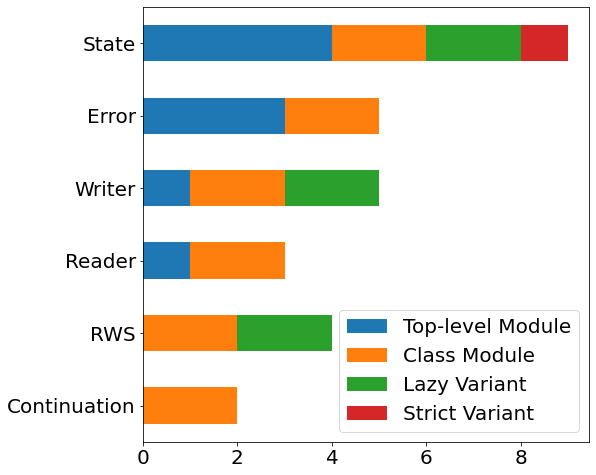

In [902]:
nomtl_ax = plt.figure(figsize=(8,8)).add_subplot(111)
nomtl_dfy = nomtlsplit_df.sort_values(by="Top-level Module")
nomtl_dfy.plot(ax=nomtl_ax, kind='barh', stacked=True, legend=True)